In [51]:
import sys
import numpy as np
from numpy import matrix
import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
import random,os
from astropy.cosmology import FlatLambdaCDM
from scipy import optimize
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
from astropy.table import Table
import numpy.ma as ma


c = 300000. # km/sec
q=-0.59 # decelertion parameter


# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + ((1-q)*z1/2)
    return (5*np.log10(t1*t2*t3)) +25

# Getting results
#filter = ['u','B','g','V','r','i','Y','J','H']

filter=['B']
for i in range(len(filter)):

    result = ascii.read('../results/'+filter[i]+'_trgb_update3_result.txt')
    #result = ascii.read('../results/F24Table4.txt')
    p0=result['p0'][0]
    ep0 = (result['p0'][1]+result['p0'][2])/2
    p1=result['p1'][0]
    ep1 = (result['p1'][1]+result['p1'][2])/2
    p2=result['p2'][0]
    ep2 = (result['p2'][1]+result['p2'][2])/2
    alpha=result['alpha'][0]
    ealpha = (result['alpha'][1]+result['alpha'][2])/2

    rv=result['beta'][0]
    erv = (result['beta'][1]+result['beta'][2])/2
    sig=result['sig_int'][0]
    vel=result['vel'][0]
    h0=result['H0'][0]
    eh0 = (result['H0'][1]+result['H0'][2])/2

    p0 =-19.19
    p1 = -1.25
    p2 = -1.23
    alpha = -0.02
    rv = 3.03
    
    tab = ascii.read('../data/working/'+filter[i]+'_trgb_update3.csv')
   
    w = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') & (tab['sn']!='PTF14yw') & (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='LSQ14fmg')& (tab['sn']!='SN2004dt')& (tab['sn']!='SN2005gj')& (tab['sn']!='SN2005hk')& (tab['sn']!='SN2006bt')& (tab['sn']!='SN2006ot')& (tab['sn']!='SN2007so')& (tab['sn']!='SN2008ae')& (tab['sn']!='SN2008bd')& (tab['sn']!='SN2008ha')& (tab['sn']!='SN2008J')& (tab['sn']!='SN2009dc')& (tab['sn']!='SN2009J')& (tab['sn']!='SN2010ae'))
    
    st = tab['st'][w]
    est = tab['est'][w]
    zhel = tab['zhel'][w]
    zcmb = tab['zcmb'][w]
    mmax = tab['Mmax'][w]
    emmax = tab['eMmax'][w]
    bv = tab['BV'][w]
    ebv = tab['eBV'][w]
    m_csp = tab['m'][w]
    ml = tab['ml'][w]
    mu = tab['mu'][w]
    eml = (tab['m'][w]-tab['ml'][w])
    emu = (tab['mu'][w]-tab['m'][w])
    em = (eml+emu)/2.
    dist = tab['dist'][w]
    edist = tab['edist'][w]
    c_ms = tab['covMs'][w]
    c_mbv = tab['covBV_M'][w]
    c_sbv = tab['covBVs'][w]

    sn = tab['sn'][w]
    sample = tab['sample'][w]
    cal = tab['caltype'][w]
    host = tab['host'][w]
    source = tab['sample'][w]
    ww =np.where(sn =='SNhunt281')
    subtype = tab['subtype'][w] 
    Ho_dist = tab['dist'][w]<0

    st1 = p1*(st - 1)
    st2 = p2*((st - 1)**2)
    red = rv*(bv)



In [52]:
    mmax_corr = mmax + st1 + st2 + red + alpha*(m_csp-np.median(m_csp)) 

    mu_model = np.where(Ho_dist,distmod(h0,zhel,zcmb), dist)
    fac= (p1+(2*p2*st))

    err = (emmax**2) + ((fac*est)**2) +((rv*ebv)**2) -(2*fac*c_ms)+(2*rv*fac*c_sbv) -(2*fac*c_mbv)+((alpha*em)**2) + (sig**2) #+ ((0.00000723*vel/zcmb)**2)
        
    err1 = (emmax**2) + ((fac*est)**2) +((rv*ebv)**2) -(2*fac*c_ms)+(2*rv*fac*c_sbv) -(2*fac*c_mbv)+((alpha*em)**2)  + (edist**2)
            
    
    mu_stat = np.where(dist<0,err,err1)
    #mu_stat=np.sqrt(err)
    
    data=Table()
    data['sn']=sn
    #data['res']=dmu

    data['mmax_snoopy'] = mmax.round(3)
    data['mmax_corrected']=mmax_corr.round(3)
    data['err_mmax']=mu_stat.round(3)
    data['host'] = host
    data['Source'] = source 
    data['Source'] = ma.filled(source, 'N/A')

    nocsp = np.where(data['Source']=='N/A')
    print(data)
    #pl.errorbar(zcmb,emmax,yerr=emmax*0,fmt='ko',alpha=0.3)
    #pl.errorbar(zcmb[nocsp],emmax[nocsp],yerr=emmax[nocsp]*0,fmt='bo',alpha=0.5)

    
    ascii.write(data,'../results/forAdam/TRGB_'+filter[i]+'.txt',format='tab',overwrite=True)
    
   


    sn    mmax_snoopy mmax_corrected err_mmax  host Source
--------- ----------- -------------- -------- ----- ------
 ASAS14ad      16.233         16.221    0.039   N/A  CSPII
 ASAS14hp      16.498         16.275    0.034   N/A  CSPII
 ASAS14hr      17.082         17.466    0.036   N/A  CSPII
 ASAS14hu      15.386         15.189    0.033   N/A  CSPII
 ASAS14jc      15.682          17.12    0.034   N/A  CSPII
 ASAS14jg      14.781         14.504    0.097   N/A  CSPII
 ASAS14jz      14.622         14.553    0.033   N/A  CSPII
 ASAS14kd      16.244          16.71    0.034   N/A  CSPII
 ASAS14kq      16.591         16.345    0.038   N/A  CSPII
 ASAS14lo      16.003         16.457     0.09   N/A  CSPII
      ...         ...            ...      ...   ...    ...
  SN2014D      17.251         19.057    0.109   N/A  CSPII
  SN2014I      16.296          16.42    0.033   N/A  CSPII
  SN2014Z       15.54         15.511    0.098   N/A  CSPII
 SN2014ao      16.919         18.884    0.033   N/A  CSP

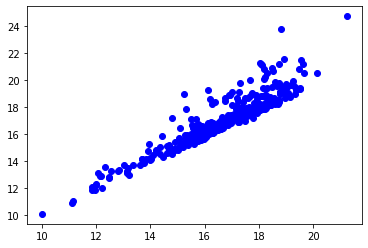

In [53]:
pl.plot(mmax, mmax_corr, 'bo')